# CSV Handling & Consolidation V1.7
Authors: Michael Lee / Sean Ng  
Date: 21 Jan 18  
Consolidates multiple SER/SEF CSV s, handles data appropriately  
Output: CSV or HDF5  with metadata.txt log   

Changelog:
* Instead of linear interpolation without limit, only do interpolation with a limit of 20.
* Chunk dataframe into smaller chunks to prevent the case of windowing over NaN values
* Semantic windowing - Fingerprinting instead of naive windowing

## Implementation
<a href="#Import-Functions">Import Functions First (Click this and Run all below that)</a>
1. Start from scratch: filelists("SE\*csv") will give entire list of CSV files, but it's not feasible to deal with all these files. Instead, use one of the following methods:

In [3]:
from scipy import stats#kurtosis, skew
DF_NAME = "2014-09-12_15min_chunked" 
LABEL_NAMES = ["level_16","level_13","level_18","level_20","level_23"] # type(LABEL_NAMES) must be a list
WIN_SIZE = 20
INTERPOLATION_LIMIT = 5
FREQUENCY = "15Min"
TRANSFORMATIONS = [lambda x:x] #transformations for semantic window

In [39]:
# (a) Wildcard files (using bash):
SE_list = filelists("SE*201409*csv SE*201410*csv SE*201411*csv SE*201412*csv")
# (b) Manually input SE_list:
# SE_list = ['SEF13_201402.csv','SEF16_201402.csv','SEF23_201402.csv']
data = concatFiles(SE_list,freq=FREQUENCY,interpolation_limit=INTERPOLATION_LIMIT)
print(len(SE_list))
#Drop columns with more than 1/6 NaN's
data = data.loc[:,data.isnull().sum() <= round(data.shape[0]/6)]
data = data.drop(['level_31','level_22','level_28'],axis=1)
print(data.isnull().sum())
print(data.shape)

68
level_13    122
level_16     20
level_18    769
level_20    708
level_23    116
rain_01      11
rain_02      10
rain_03      22
rain_04       9
rain_05      15
rain_06      13
dtype: int64
(11712, 11)


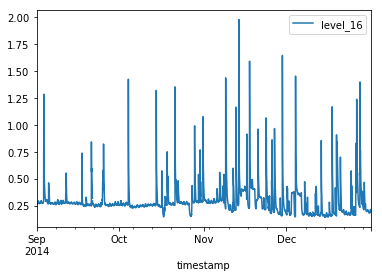

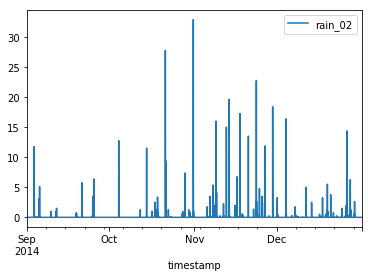

In [40]:
data[['level_16']].plot()#figsize=(20,10))
data[['rain_02']].plot()#figsize=(20,10))



### Transformations

In [11]:
print(data.shape)
levels = data.loc[:,data.columns.str.find('level')>=0]
rains = data.loc[:,data.columns.str.find('rain')>=0]


levels.shape,rains.shape,velocities.shape

(11712, 22)


((11712, 8), (11712, 6), (11712, 8))

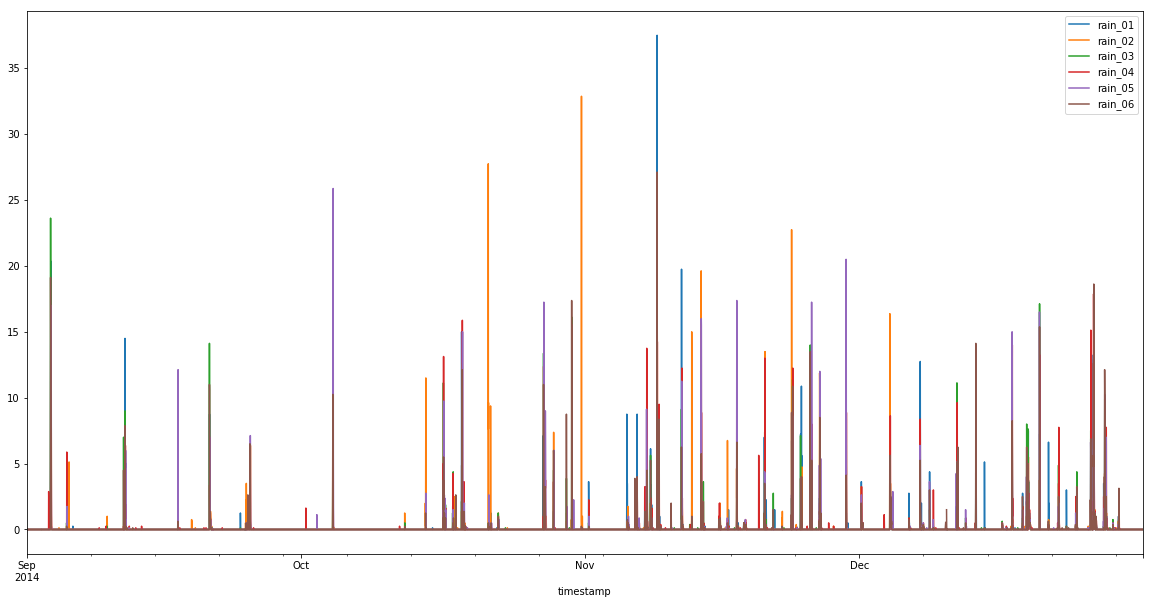

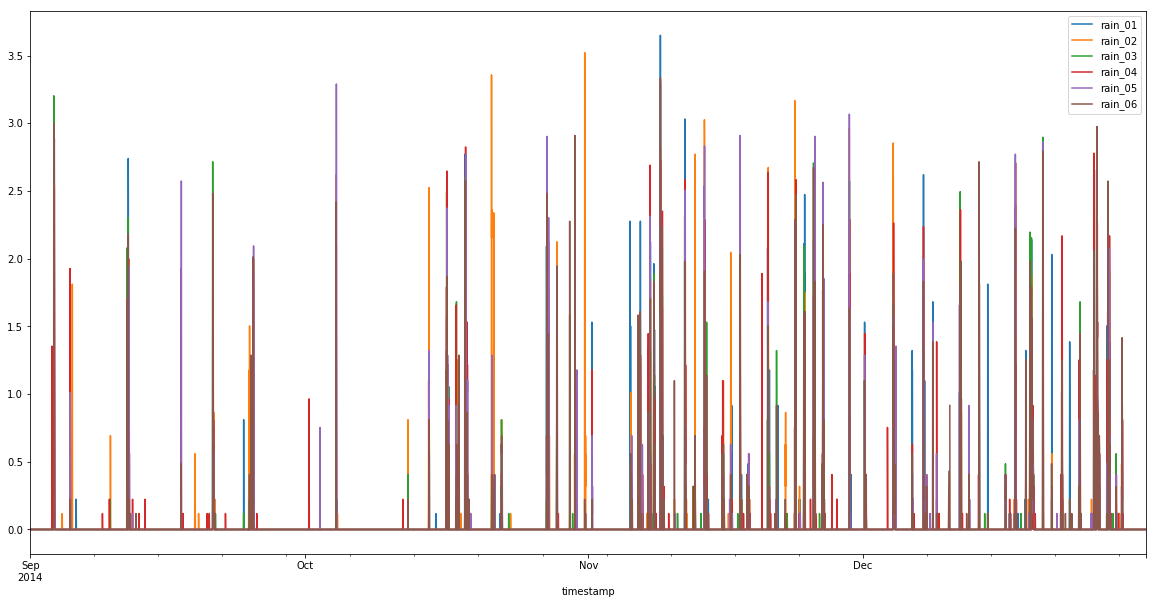

In [41]:
# R(1) Log(rains+1)
rains.plot(figsize=(20,10))
log_rains = rains.apply(lambda x: np.log(x+1))#.plot(figsize=(20,10))
log_rains.plot(figsize=(20,10))

In [42]:
#reintegrate transformations
data = levels.join([log_rains],how='outer')
data = data.sort_index(axis=1) #to allow consistent column specification in h5py file

In [43]:
print(data.shape,'\n',data.columns)

(11712, 14) 
 Index(['level_13', 'level_16', 'level_18', 'level_20', 'level_22', 'level_23',
       'level_28', 'level_31', 'rain_01', 'rain_02', 'rain_03', 'rain_04',
       'rain_05', 'rain_06'],
      dtype='object')


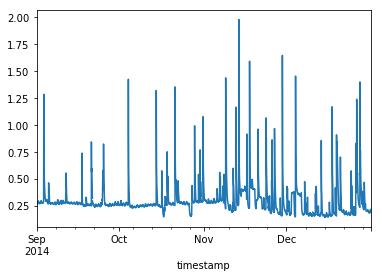

In [44]:
data.level_16.plot()

### Filtration

In [45]:
#Takes in dataframe and filters out data with nans and concatenates them into a window.
def data_filtering(df,window_size,labels):
    """
    Assume no duplicates in index
    Takes in int window_size and list of label names
    """
    assert df.index.duplicated().sum() == 0, "Duplicate timestamps detected!"
    
    rowIsfull = df.apply(lambda x: x.count() == len(x),axis=1)
    partitionIndex = (rowIsfull != rowIsfull.shift(1)).cumsum() #shift downwards and find interfaces
   
    #Only work with clean data
    gb = df[rowIsfull].groupby(partitionIndex)
    # gb.filter(lambda x: len(x)>39) #Alternate method, but doesn't allow windowing of groups individually
    #counter = 0    
    for i,g in enumerate(gb):
        chunk = g[1] #access the dictionary value, which is the dataframe
        
        d = windowDatLbl(chunk,window_size,True)
        ls = {} #iterative label dict
        for l in labels:
            ls[l] = windowDatLbl(chunk,window_size,False,l)
        if i == 0: #initialize
            dat_arr = d
            lbl_arrs = ls #global label dict
        else:
            dat_arr = np.concatenate((dat_arr,d))
            for l in lbl_arrs:
                lbl_arrs[l] = np.concatenate((lbl_arrs[l],ls[l]))
                
    return dat_arr,lbl_arrs

In [47]:
dat_arr,lbl_arrs = data_filtering(data,WIN_SIZE,LABEL_NAMES)

In [48]:
dat_arr.shape,lbl_arrs['level_16'].shape

((6429, 14, 20), (6429, 20))

In [ ]:
dat_arr = semanticWindow(dat_arr,TRANSFORMATIONS)
for l in lbl_arrs:
    lbl_arrs[l] = semanticWindow(lbl_arrs[l],TRANSFORMATIONS)

In [49]:
dat_arr.shape,lbl_arrs['level_16'].shape

((6429, 14, 20), (6429, 20))

In [50]:
dat_arr[9,1,:]

array([ 0.2754 ,  0.2754 ,  0.27846,  0.27846,  0.28152,  0.28152,
        0.2822 ,  0.28356,  0.28662,  0.28662,  0.28662,  0.28662,
        0.28662,  0.28662,  0.28662,  0.28662,  0.28662,  0.28662,
        0.28968,  0.2907 ])

### Export to CSV/HDF5 Files

In [51]:
#Write .h5, .csv and metadata files
#data.to_csv(DF_NAME+".csv")

for l in lbl_arrs:
    if not os.path.isdir(l):
        !mkdir $l
    tohdf5(dat_arr,lbl_arrs[l],directory=l)

    with open(l+"/metadata.txt","w") as f:

        log = "NAME: " + DF_NAME + ".csv" + "\n"
        log += "Overall Data Blob: " + str(dat_arr.shape) + "\n"

        log += "Window Size: " + str(WIN_SIZE) + "\n"
        log += "Label: " + l + "\n"
        log += "First timestamp: " + str(data.index.values[WIN_SIZE-1]) + "\n"
        log += "Transformations used in semantic window: \n"
        for i,t in enumerate(TRANSFORMATIONS):
            log += str(i) + ". " + str(t) + "\n"
        log += "Columns: \n"
        cols = list(data.keys())
        for i,c in enumerate(cols):
            log += str(i) + ". " + c + "\n"

        f.write(log)

### Verify and Visualize HDF5 Files

In [15]:
for l in LABEL_NAMES:
    print("In "+l)
    train_h5 = h5py.File(l+'/train.h5','r')
    for k in train_h5:
        print(k,":",train_h5[k])
    train_h5.close()

In level_16
data : <HDF5 dataset "data": shape (5143, 14, 20), type "<f8">
label : <HDF5 dataset "label": shape (5143, 20), type "<f8">
In level_13
data : <HDF5 dataset "data": shape (5143, 14, 20), type "<f8">
label : <HDF5 dataset "label": shape (5143, 20), type "<f8">
In level_18
data : <HDF5 dataset "data": shape (5143, 14, 20), type "<f8">
label : <HDF5 dataset "label": shape (5143, 20), type "<f8">
In level_20
data : <HDF5 dataset "data": shape (5143, 14, 20), type "<f8">
label : <HDF5 dataset "label": shape (5143, 20), type "<f8">
In level_23
data : <HDF5 dataset "data": shape (5143, 14, 20), type "<f8">
label : <HDF5 dataset "label": shape (5143, 20), type "<f8">


data  :  (1286, 14, 20)
label  :  (1286, 20)
float64


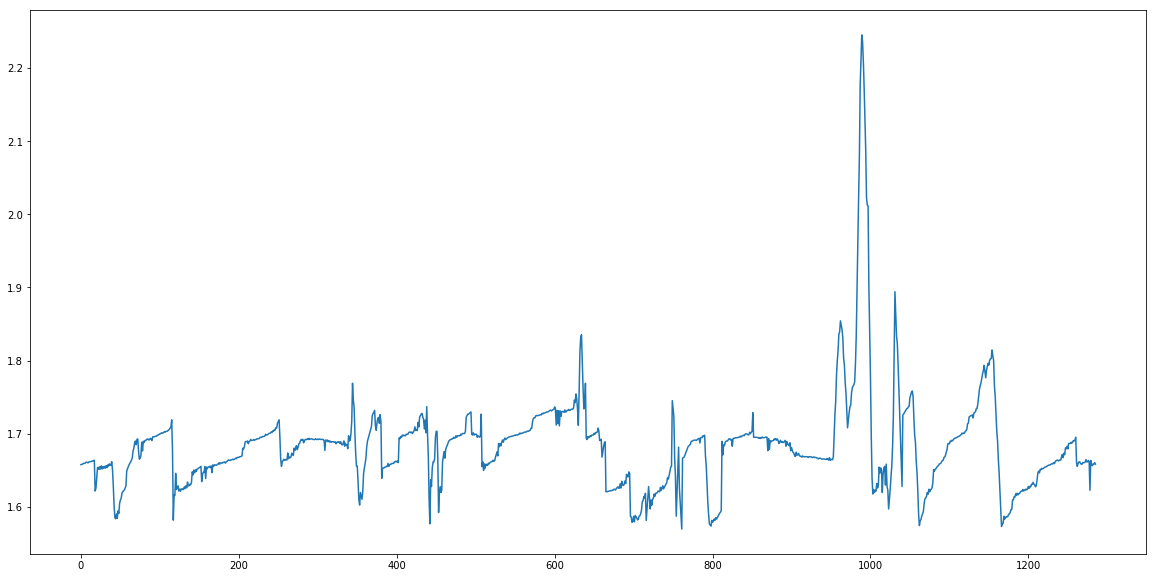

In [17]:
import matplotlib.pyplot as plt
with h5py.File('level_13/test.h5','r') as f:
    for k in f.keys():
        print(k," : ", f[k].shape)
    dat_set = f['data'][:,0,0]
    lbl_set = f['label'][:,3]
    print(dat_set.dtype)
    plt.close()
    plt.figure(1,figsize=(20,10))
    #plt.plot(dat_set)
    plt.plot(lbl_set)
    #plt.legend(["rain"])
    plt.show

## Import Functions

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import h5py
import os

%matplotlib inline

### Average Columns (Rainfall)

In [33]:
#For Rainfall
def averageCols(df):
    cond1 = (~np.isnan(df['rainfall A(mm)']))&(~np.isnan(df['rainfall B(mm)']))
    cond2 = np.isnan(df['rainfall A(mm)']) & (~np.isnan(df['rainfall B(mm)']))
    cond3 = (~np.isnan(df['rainfall A(mm)'])) & np.isnan(df['rainfall B(mm)'])
    ser = np.where(cond1,(df['rainfall A(mm)'] + df['rainfall B(mm)'])/2,
                   np.where(cond2, df['rainfall A(mm)'],
                            np.where(cond3,df['rainfall B(mm)'],np.nan)))
    return pd.DataFrame(ser,index = df.index)

### Handle Station Data for each CSV file
resamples data from arbitrary time frequency to 5Min frequency
https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-resampling

In [34]:
def handle_station_data(s,freq='5Min',interpolation_limit=0):
    """
    Input: CSV filename (string), Frequency of timestamp (string) (default: 5Min)
    Output: Dataframe with appropriate index and columns
    tolerance = 1440min (1 day) by default (exclude column if there is a day of data missing)
    """
    df = pd.read_csv(s)
    s_typ, s_num = s[:3], s[3:5]

    df['timestamp'] = pd.to_datetime(df.timestamp)

    #Canal Data
    if s_typ == "SEF":
        df.dropna(how='any',inplace=True) #to deal with 'NaN' channel cells
        df.drop('channel (m)',axis=1,inplace=True) #drop 'channel' column
        df.drop('velocity (m/s)',axis=1,inplace=True)
        df.set_index('timestamp',inplace=True)
        df.columns = ['level_'+str(s_num)] #rename columns
        
        # Upsample to 1Min intervals and deal with duplicates by taking the average
        df = df.resample("1Min").mean()
        if interpolation_limit > 0:
            df = df.interpolate(method='time',limit=interpolation_limit)
        df = df.resample(freq).asfreq()
        
    #Rainfall Data
    elif s_typ == "SER":
        df.set_index('timestamp',inplace=True)
        df = averageCols(df)
        df.columns = ['rain_'+str(s_num)]
        # Upsample to freq intervals and accumulate (sum) rainfall
        df = df.resample(freq).sum()
    
    return df

## Joining of CSV files
Note: If you attempt to join all CSV files, it will take REALLY LONG  
Read Implementation Notes. Advised to batch CSV files

In [35]:
# Helper Functions
def filelists(search):
    """
    Input: None
    Returns list of csv filenames matching search
    *Requires bash input '!'
    """
    !ls $search > SE.tmp
    f = open("SE.tmp","r")
    fl = [l.rstrip("\n") for l in f]
    f.close()
    !rm SE.tmp
    return fl[:]

def concatFiles(fl,freq="15Min",interpolation_limit=0):
    """
    Input: Filelist of CSV files to concatenate, frequency of timeseries to concatenate to
    Output: Concatenated Dataframe
    """
    df_all = pd.DataFrame()
    for s in fl:
        s_id = s[:5]
        df = handle_station_data(s,freq,interpolation_limit)
        try:
            # join as a column
            df_all = df_all.join(df,how="outer")
        except ValueError:
            # column name conflict -> column exists -> concatenate below
            df_all = pd.concat([df_all,df],axis=0)
    
    # Remove duplicate timestamps by taking their averages 
    df_all = df_all.resample(freq).mean()
    
    if interpolation_limit > 0:
        df_all = df_all.interpolate(method='time',limit=interpolation_limit)
    
    return df_all

## Window Functions
As we are doing a timeseries prediction, we'll need a window of data rather than a single data point. 
* Effectively, this would mean adding an extra dimension in the 'data' dataframe, from (t d) to (t-w d w). 
* Similarly, the column we wish to predict - the label blob - must be windowed according to the maximum time horizon we aim to predict. This transforms the column from (t 1) to (t-w w)    
**t**: number of time intervals  
**d**: number of data channels  
**w**: size of window  / time horizon

In [36]:
def windowDatLbl(df,window_size,datTrue_lblFalse=True,label=""):
    """
    Takes in dataframe of shape (t d)
    Outputs dat_arr: (t-2w+1 d w)
    Assumes time_horizon = window_size
    Returns dat_arr, lbl_arr
    """
    # Set-up
    t,d,w = df.shape[0],df.shape[1],window_size
    upp_bound = t - 2*w + 1 #change this expression if time_horizon not equal to window_size
    if not datTrue_lblFalse: assert label in df.keys(), "Label name not found"
    # Filter out small chunks
    if upp_bound <= 0:
        if datTrue_lblFalse: return np.empty((0,d,w))
        else: return np.empty((0,w))
    
    for i in range(w):
        # imagine taking a snapshot as you move down the time axis, stacking each snapshot along axis 2
        # taking w snapshots will give w windows in axis 2
        if datTrue_lblFalse: snapshot_dat = df.iloc[i:upp_bound+i].as_matrix()[:,:,np.newaxis] #to prepare to stack in axis 2
        else: snapshot_lbl = df[[label]].iloc[w+i:upp_bound+w+i].as_matrix() #offset by w, since first label only begins at index w
        
        if i == 0:
            #initialize dat_arr
            if datTrue_lblFalse: dat_arr = snapshot_dat
            else: lbl_arr = snapshot_lbl
        else:
            if datTrue_lblFalse: dat_arr = np.concatenate((dat_arr,snapshot_dat),axis=2)
            else: lbl_arr = np.concatenate((lbl_arr,snapshot_lbl),axis=1)
    
    if datTrue_lblFalse: return dat_arr
    else: return lbl_arr

def semanticWindow(arr,translist):
    """
    Takes in windowed array arr
    Transforms along last axis according to functions in translist
    """
    def func1d(arr_1d):
        """
        function applied to 1d np arrays
        """
        return np.array([f(arr_1d) for f in translist])
            
    arr = np.apply_along_axis(func1d,axis=-1,arr=arr)
    
    return arr

## Export to HDF5
Export to train.h5 and test.h5 according to 80/20 rule, and output a metadata.txt

In [37]:
def tohdf5(dat_arr,lbl_arr,directory="."):
    """
    Input: 
        3-dimensional dat_arr (t-w d w)
        2-dimensional lbl_arr (t-w w)
        optionally, directory to store train.h5 and test.h5
    Output: None 
    Writes train.h5 and test.h5
    """
    assert dat_arr.shape[0]==lbl_arr.shape[0], "Axis 0 mismatch between dat_arr and lbl_arr"
    
    #80% training, 20% test distribution rule
    train_set_length = round(0.8*dat_arr.shape[0])
    train_data = dat_arr[:train_set_length,:,:]
    test_data = dat_arr[train_set_length:,:,:]
    
    train_label = lbl_arr[:train_set_length,:]
    test_label = lbl_arr[train_set_length:,:]
    
    with h5py.File(directory+'/train.h5','w') as f:
        f.create_dataset('data',data=train_data)
        f.create_dataset('label',data=train_label)
        
    with h5py.File(directory+'/test.h5','w') as f:
        f.create_dataset('data',data=test_data)
        f.create_dataset('label',data=test_label)
    return None

#### Proofs of concept

#Normalisation
#<code>   
a = pd.DataFrame({'t':[1,2,3,4,5],'A':[2,1,3,2,12],'B':[1,4,2,5,12]})
a.set_index(['t'],inplace=True)
a[['B']].plot()
n = a.iloc[:round(0.8*len(a))].apply(np.mean)
s = a.iloc[:round(0.8*len(a))].apply(np.std)
((a-n)/s)[['B']].plot()
#</code>

Window Data Frame

#<code>
a = pd.DataFrame({'t':[1,2,3,4,5,6,7],'A':[1,3,5,7,9,11,13],'B':[2,4,6,8,10,12,14]})
a.set_index(['t'],inplace=True)
d,l = windowDatLbl(a,label='A',window_size=3)
print("Starting DataFrame: \n Shape: ",a.shape,"\n", a,"\n")
print("Data Blob ", d.shape, "\n", d)
print("Label Blob ", l.shape, "\n", l)
#</code>

t_d,t_l = semanticWindow(d,l,[np.mean,np.std])
print("Data Blob ", t_d.shape, "\n", t_d)
print("Label Blob ", t_l.shape, "\n", t_l)

<code>
a = pd.DataFrame({'t':[0,1,2,3,3,5,6,7,8],'A':np.arange(1,10),'B':np.arange(10,19)})
a.set_index(['t'],inplace=True)
d,l = windowDataFrame(a,'A',window_size=3)
print(d)
print(l)
a[~a.index.duplicated()]
</code>

#<code>
a = pd.DataFrame({'t':[1,2,3],'A':[1,3,5],'B':[2,4,6]})
#a.set_index(['t'],inplace=True)
#b = pd.DataFrame({'t':[4,5,6],'B':[10,11,12]})
#b.set_index(['t'],inplace=True)
#c = pd.DataFrame({'t':[4,5,6],'A':[2,2,2]})
#c.set_index(['t'],inplace=True)
#d = pd.concat([a,b,c])
#d.groupby('t').agg(np.max)
#</code>
a

Interpolation

<code>
a = pd.DataFrame({'time':['2014-02-01 01:01:00','2014-02-01 01:03:00','2014-02-01 01:10:00'],'A':[1,1.3,1.6],'B':[2,10,8]})
a.time = pd.to_datetime(a.time)
a = a.set_index(['time'])
#a = a.resample('A')
a = a.asfreq('1T')
a.interpolate(method='time')
</code>

<a href="#Implementation">TOP</a>